In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS
from tqdm import tqdm
import scipy.io
import sys

sys.path.append("../")
sys.path.append("../..")
from util import *
from model.qres import QRes

In [2]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:2'

In [3]:
res, b_left, b_right, b_upper, b_lower = get_data([0,2*np.pi], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([0,2*np.pi], [0,1], 101, 101)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
# Train QRes 
model = QRes(in_dim=2, hidden_dim=512, out_dim=1, num_layer=2).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

/tmp/ipykernel_260884/93869651.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


QRes(
  (inlayer): QRes_block(
    (H1): Linear(in_features=2, out_features=512, bias=True)
    (H2): Linear(in_features=2, out_features=512, bias=True)
    (act): Sigmoid()
  )
  (layers): ModuleList(
    (0): QRes_block(
      (H1): Linear(in_features=512, out_features=512, bias=True)
      (H2): Linear(in_features=512, out_features=512, bias=True)
      (act): Sigmoid()
    )
  )
  (outlayer): Linear(in_features=512, out_features=1, bias=True)
)
528897


In [10]:
loss_track = []

for i in tqdm(range(500)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        u = pred_res
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        loss_res = torch.mean((u_t + u * u_x) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - torch.sin(x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + loss_bc + loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 500/500 [03:17<00:00,  2.53it/s]


In [11]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

Loss Res: 0.000262, Loss_BC: 0.000002, Loss_IC: 0.000190
Train Loss: 0.000454


/tmp/ipykernel_260884/2576373100.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)


relative L1 error: 0.019700
relative L2 error: 0.040984


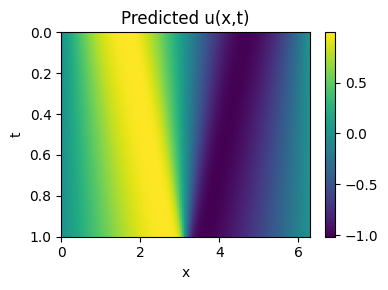

In [12]:
# Visualize QRes 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(101,101)

mat = scipy.io.loadmat('./burgers.mat')
u = mat['u'].reshape(101,101)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_qres_pred.png')
plt.show()

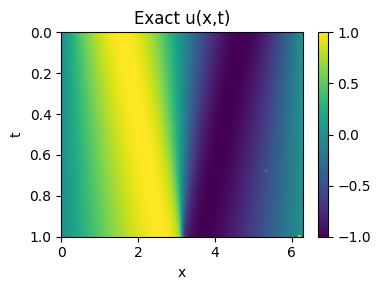

In [13]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_exact.png')
plt.show()

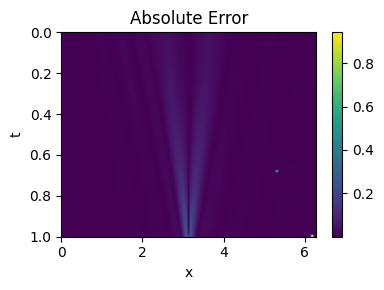

In [14]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,np.pi*2,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./image/burgers_qres_error.png')
plt.show()